# Classifying whether an ETF goes up or down
## Here we will use the data of the ETF we are prediciting and not any other data

#### Importing required libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from sklearn import svm
from sklearn.model_selection import TimeSeriesSplit
import warnings
warnings.filterwarnings('ignore')

C:\Users\Akshay\Anaconda3_1\lib\site-packages\dask\dataframe\utils.py:13: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
C:\Users\Akshay\Anaconda3_1\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
%run Feature_Creation.ipynb
%run Auxillary_Functions.ipynb

## Importing data

#### Importing data and generating features

In [3]:
SPY = pd.read_csv(os.path.join(os.path.abspath(os.getcwd()),'data','largecap','SPY.csv'))

SPY_feat = create_features(SPY)

SPY_feat.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Month_1,Month_2,Month_3,...,RSI_overbought,RSI_oversold,prev_hot_streak,prev_cold_streak,current_hot_streak,current_cold_streak,prev_current_hot,prev_current_cold,current_hot_prev_cold,current_cold_prev_hot
0,2015-01-12,204.410004,204.600006,201.919998,202.649994,181.766663,144396100,1,0,0,...,False,False,2.0,3.0,0.0,2.0,2.0,1.0,-3.0,0.0
1,2015-01-13,204.119995,205.479996,200.509995,202.080002,181.255432,214553300,1,0,0,...,False,False,2.0,3.0,0.0,3.0,2.0,0.0,-3.0,1.0
2,2015-01-14,199.649994,201.100006,198.570007,200.860001,180.161163,192991100,1,0,0,...,False,False,2.0,3.0,0.0,4.0,2.0,-1.0,-3.0,2.0
3,2015-01-15,201.630005,202.009995,198.880005,199.020004,178.510773,176613900,1,0,0,...,False,True,2.0,3.0,0.0,5.0,2.0,-2.0,-3.0,3.0
4,2015-01-16,198.770004,201.820007,198.550003,201.630005,180.851807,211879600,1,0,0,...,False,False,2.0,5.0,1.0,0.0,1.0,5.0,-4.0,-2.0


#### Normalizing features

In [8]:
y = SPY_feat['target'].astype(int)
X = SPY_feat.drop(['Date','Adj Close','High','Low','Close','target'],axis=1)

continuous = ['1day_pct', '2day_pct', '3day_pct', '4day_pct', '5day_pct', '7day_pct',
              '1day_pct_cs',
              'ewma_7', 'ewma_50', 'ewma_200', 'RSI', 'MACD','Volume','day_var','open_close','open_prev_close','high_close']
discrete = ['prev_hot_streak','prev_cold_streak', 'current_hot_streak', 'current_cold_streak',
            'RSI_overbought','RSI_oversold',
            #'7g(50&200)','7l(50&200)','7g50','7g200',
            'prev_current_hot', 'prev_current_cold','current_hot_prev_cold','current_cold_prev_hot',
            'Month_1', 'Month_2', 'Month_3', 'Month_4', 'Month_5', 'Month_6',
            'Month_7', 'Month_8', 'Month_9', 'Month_10', 'Month_11', 'Month_12',
            'dayowk_0', 'dayowk_1', 'dayowk_2', 'dayowk_3', 'dayowk_4',
           ]
scaler = StandardScaler()
X_cont = pd.DataFrame(scaler.fit_transform(X[continuous]),columns=continuous)

X_disc = X[discrete]

X_cont.reset_index(drop=True,inplace=True)

X_disc.reset_index(drop=True,inplace=True)

X = pd.concat([X_cont,X_disc],axis=1)


X_test = X.iloc[1000:]
X_train = X.iloc[0:1000]
y_test = y.iloc[1000:]
y_train = y.iloc[0:1000]

tscv = TimeSeriesSplit(n_splits=4)
print(tscv.split(X_train))
for train, val in tscv.split(X_train):
    print("%s %s" % (train, val))

<generator object TimeSeriesSplit.split at 0x000002B01E3DB8B8>
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199] [200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217
 218 219 220 221 222 223 224 225 226 227 228 229 23

# Analysis

### Naive Prediction. Up everyday

In [9]:
y_hat_test_naive = np.ones(len(y_test))
print('precision score' ,precision_score(y_hat_test_naive,y_test))
print('recall score' ,recall_score(y_hat_test_naive,y_test))
print('accuracy score' ,accuracy_score(y_hat_test_naive,y_test))
print('f1 score' ,f1_score(y_hat_test_naive,y_test))

precision score 1.0
recall score 0.592
accuracy score 0.592
f1 score 0.743718592964824


### Random Forests not tuned

In [10]:
forest = RandomForestClassifier(n_estimators=3000, max_depth= 10)
forest.fit(X_train, y_train)
print(forest.score(X_test, y_test))

plot_feature_importances(forest,n_features=50)

0.492

In [8]:
y_hat_test = forest.predict(X_test)
print('precision score' ,precision_score(y_hat_test,y_test))
print('recall score' ,recall_score(y_hat_test,y_test))
print('accuracy score' ,accuracy_score(y_hat_test,y_test))
print('f1 score' ,f1_score(y_hat_test,y_test))
print(y_test.value_counts()/y_test.value_counts().sum())

precision score 0.3918918918918919
recall score 0.6041666666666666
accuracy score 0.488
f1 score 0.47540983606557374
1    0.592
0    0.408
Name: target, dtype: float64


### Random Forest tuned using GridSearch

In [9]:
rf_clf = RandomForestClassifier()
rf_param_grid = {
    'n_estimators': [5,7,10,30,50],
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 2, 3, 5,10],
    'min_samples_split': [5,10,15],
    'min_samples_leaf': [3,5,9,13]
}
rf_grid_search = GridSearchCV(rf_clf, rf_param_grid, cv=tscv)
rf_grid_search.fit(X_train, y_train)

print(f"Training Accuracy: {rf_grid_search.best_score_ :.2%}")
print("")
print(f"Optimal Parameters: {rf_grid_search.best_params_}")

y_hat_test_RF = rf_grid_search.predict(X_test)
RF_dict = {'model':'RF','precision':precision_score(y_hat_test_RF,y_test),'recall':recall_score(y_hat_test_RF,y_test),
           'accuracy':accuracy_score(y_hat_test_RF,y_test),'f1':f1_score(y_hat_test_RF,y_test)}

print(RF_dict)

print(np.nansum((np.array(X_test['1day_pct'].shift(-1))*((np.array(y_hat_test_RF)-1/2)*2))))

print(np.nansum((np.array(X_test['1day_pct'].shift(-1))*(np.array(y_hat_test_naive)))))

Training Accuracy: 55.25%

Optimal Parameters: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 13, 'min_samples_split': 5, 'n_estimators': 5}
{'model': 'RF', 'precision': 0.581081081081081, 'recall': 0.589041095890411, 'accuracy': 0.512, 'f1': 0.5850340136054422}
-6.791378506797381
19.214327287585224


### Logistic Regression

In [10]:
logreg_clf = LogisticRegression()
logreg_param_grid = {
    'fit_intercept': [True,False],
    'solver':['liblinear'],
    'C': np.logspace(0,4,5),
    'penalty': ['l2'],
}
logreg_grid_search = GridSearchCV(logreg_clf, logreg_param_grid, cv=tscv)
logreg_grid_search.fit(X_train, y_train)

print(f"Training Accuracy: {logreg_grid_search.best_score_ :.2%}")
print("")
print(f"Optimal Parameters: {logreg_grid_search.best_params_}")

Training Accuracy: 51.62%

Optimal Parameters: {'C': 10.0, 'fit_intercept': True, 'penalty': 'l2', 'solver': 'liblinear'}


In [11]:
y_hat_test_log = logreg_grid_search.predict(X_test)
logreg_poly_dict = {'model':'SVM_poly','precision':precision_score(y_hat_test,y_test),'recall':recall_score(y_hat_test,y_test),
           'accuracy':accuracy_score(y_hat_test,y_test),'f1':f1_score(y_hat_test,y_test)}

In [12]:
logreg_poly_dict

{'model': 'SVM_poly',
 'precision': 0.3918918918918919,
 'recall': 0.6041666666666666,
 'accuracy': 0.488,
 'f1': 0.47540983606557374}

## SVM

In [13]:
clf = svm.SVC(kernel='linear')
clf.fit(X_train,y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [14]:
svm_clf = svm.SVC()
C_range = np.array([50., 100., 200., 500.])
gamma_range = np.array([0.0001,3*0.0001,0.001,3*0.001])
svm_param_grid = dict(gamma=gamma_range, C=C_range)

svm_grid_search = GridSearchCV(svm_clf, svm_param_grid, cv=tscv)
svm_grid_search.fit(X_train, y_train)

print(f"Training Accuracy: {svm_grid_search.best_score_ :.2%}")
print("")
print(f"Optimal Parameters: {svm_grid_search.best_params_}")

Training Accuracy: 55.00%

Optimal Parameters: {'C': 100.0, 'gamma': 0.0001}


In [15]:
y_hat_test_svm = svm_grid_search.predict(X_test)
SVM_dict = {'model':'SVM','precision':precision_score(y_hat_test_svm,y_test),'recall':recall_score(y_hat_test_svm,y_test),
           'accuracy':accuracy_score(y_hat_test_svm,y_test),'f1':f1_score(y_hat_test_svm,y_test)}

In [16]:
SVM_dict

{'model': 'SVM',
 'precision': 0.8175675675675675,
 'recall': 0.5931372549019608,
 'accuracy': 0.56,
 'f1': 0.6874999999999999}

In [17]:
svm_clf_poly = svm.SVC(kernel='poly')
r_range =  np.array([0.25,0.5, 1,2,4])
gamma_range =  np.array([0.0001,0.001, 0.01,0.1])
d_range = np.array([2,3, 4])
param_grid = dict(gamma=gamma_range, degree=d_range, coef0=r_range)
svm_grid_search_poly = GridSearchCV(svm_clf_poly, param_grid, cv=tscv)
svm_grid_search_poly.fit(X_train, y_train)

print(f"Training Accuracy: {svm_grid_search_poly.best_score_ :.2%}")
print("")
print(f"Optimal Parameters: {svm_grid_search_poly.best_params_}")

Training Accuracy: 55.12%

Optimal Parameters: {'coef0': 4.0, 'degree': 4, 'gamma': 0.0001}


In [18]:
y_hat_test_svm_poly = svm_grid_search_poly.predict(X_test)
SVM_poly_dict = {'model':'SVM_poly','precision':precision_score(y_hat_test_svm_poly,y_test),'recall':recall_score(y_hat_test_svm_poly,y_test),
           'accuracy':accuracy_score(y_hat_test_svm_poly,y_test),'f1':f1_score(y_hat_test_svm_poly,y_test)}

In [19]:
SVM_poly_dict

{'model': 'SVM_poly',
 'precision': 0.7905405405405406,
 'recall': 0.5879396984924623,
 'accuracy': 0.548,
 'f1': 0.6743515850144092}

In [21]:
np.nansum((np.array(X_test['1day_pct'].shift(-1))*((np.array(y_hat_test_svm)-1/2)*2)))

11.120800232893803

## Gradient Boosting Classifier

In [22]:
model = XGBClassifier()

In [23]:
model.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
       importance_type='gain', interaction_constraints='',
       learning_rate=0.300000012, max_delta_step=0, max_depth=6,
       min_child_weight=1, missing=nan, monotone_constraints='()',
       n_estimators=100, n_jobs=0, num_parallel_tree=1,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
       validate_parameters=1, verbosity=None)

In [24]:
model.score(X_test,y_test)

0.52

In [25]:
estimator = XGBClassifier(
    objective= 'binary:logistic',
    nthread=2,
    seed=42
)
parameters = {
    'max_depth': range (2, 10, 1),
    'n_estimators': range(20, 120, 10),
    'learning_rate': [0.001,0.003,0.01, 0.03, 0.1]
}

grid_search = GridSearchCV(
    estimator=estimator,
    param_grid=parameters,
    n_jobs = 10,
    cv = tscv,
    verbose=True
)
grid_search.fit(X_train, y_train)
print(f"Training Accuracy: {grid_search.best_score_ :.2%}")
print("")
print(f"Optimal Parameters: {grid_search.best_params_}")

y_hat_test_XGB = grid_search.predict(X_test)
XGB_dict = {'model':'XGB','precision':precision_score(y_hat_test_XGB,y_test),'recall':recall_score(y_hat_test_XGB,y_test),
           'accuracy':accuracy_score(y_hat_test_XGB,y_test),'f1':f1_score(y_hat_test_XGB,y_test)}

print(XGB_dict)

print(np.nansum((np.array(X_test['1day_pct'].shift(-1))*((np.array(y_hat_test_XGB)-1/2)*2))))

print(np.nansum((np.array(X_test['1day_pct'].shift(-1))*np.ones(len(y_test)))))

Fitting 4 folds for each of 400 candidates, totalling 1600 fits


[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:   19.9s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:   34.4s
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed:  1.1min
[Parallel(n_jobs=10)]: Done 780 tasks      | elapsed:  1.9min
[Parallel(n_jobs=10)]: Done 1230 tasks      | elapsed:  3.0min
[Parallel(n_jobs=10)]: Done 1600 out of 1600 | elapsed:  3.9min finished


Training Accuracy: 53.50%

Optimal Parameters: {'learning_rate': 0.03, 'max_depth': 6, 'n_estimators': 50}
{'model': 'XGB', 'precision': 0.581081081081081, 'recall': 0.6466165413533834, 'accuracy': 0.564, 'f1': 0.6120996441281138}
29.14715184346195
19.214327287585224


In [26]:
stacked_y = []
for i in range(len(y_test)):
    l = np.array([y_hat_test_RF[i],y_hat_test_log[i],y_hat_test_svm[i],y_hat_test_XGB[i]])
    counts = np.bincount(l)
    stacked_y.append(np.argmax(counts))
stacked_y = np.array(stacked_y)
stacked_dict = {'model':'Stacked','precision':precision_score(stacked_y,y_test),'recall':recall_score(stacked_y,y_test),
           'accuracy':accuracy_score(stacked_y,y_test),'f1':f1_score(stacked_y,y_test)}

In [27]:
stacked_dict

{'model': 'Stacked',
 'precision': 0.5540540540540541,
 'recall': 0.5985401459854015,
 'accuracy': 0.516,
 'f1': 0.5754385964912281}

# Gold Predictions XGB

In [19]:
GLD = pd.read_csv(os.path.join(os.path.abspath(os.getcwd()),'data','other','gold.csv'))

GLD_feat = create_features(GLD)

GLD_feat.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Month_1,Month_2,Month_3,...,RSI_overbought,RSI_oversold,prev_hot_streak,prev_cold_streak,current_hot_streak,current_cold_streak,prev_current_hot,prev_current_cold,current_hot_prev_cold,current_cold_prev_hot
0,2015-01-09,1211.099976,1220.199951,1210.300049,1216.000000,1216.000000,43.0,1,0,0,...,False,False,2.0,2.0,1.0,0.0,1.0,2.0,-1.0,-2.0
1,2015-01-13,1239.199951,1239.300049,1230.300049,1234.300049,1234.300049,20.0,1,0,0,...,True,False,1.0,1.0,2.0,0.0,-1.0,1.0,1.0,-1.0
2,2015-01-14,1229.599976,1243.800049,1225.599976,1234.400024,1234.400024,21.0,1,0,0,...,True,False,1.0,1.0,3.0,0.0,-2.0,1.0,2.0,-1.0
3,2015-01-15,1231.500000,1265.000000,1227.300049,1264.699951,1264.699951,130.0,1,0,0,...,True,False,1.0,1.0,4.0,0.0,-3.0,1.0,3.0,-1.0
4,2015-01-16,1256.099976,1279.699951,1256.099976,1276.900024,1276.900024,44.0,1,0,0,...,True,False,1.0,1.0,5.0,0.0,-4.0,1.0,4.0,-1.0


In [29]:
y = GLD_feat['target'].astype(int)
X = GLD_feat.drop(['Date','Adj Close','High','Low','Close','target'],axis=1)

continuous = ['1day_pct', '2day_pct', '3day_pct', '4day_pct', '5day_pct', '7day_pct',
              '1day_pct_cs',
              'ewma_7', 'ewma_50', 'ewma_200', 'RSI', 'MACD','Volume','day_var','open_close','open_prev_close','high_close']
discrete = ['prev_hot_streak','prev_cold_streak', 'current_hot_streak', 'current_cold_streak',
            'RSI_overbought','RSI_oversold',
            #'7g(50&200)','7l(50&200)','7g50','7g200',
            'prev_current_hot', 'prev_current_cold','current_hot_prev_cold','current_cold_prev_hot',
            'Month_1', 'Month_2', 'Month_3', 'Month_4', 'Month_5', 'Month_6',
            'Month_7', 'Month_8', 'Month_9', 'Month_10', 'Month_11', 'Month_12',
            'dayowk_0', 'dayowk_1', 'dayowk_2', 'dayowk_3', 'dayowk_4',
           ]
scaler = StandardScaler()
X_cont = pd.DataFrame(scaler.fit_transform(X[continuous]),columns=continuous)

X_disc = X[discrete]

X_cont.reset_index(drop=True,inplace=True)

X_disc.reset_index(drop=True,inplace=True)

X = pd.concat([X_cont,X_disc],axis=1)

train_size = X.shape[0]*4//5
X_test = X.iloc[train_size:]
X_train = X.iloc[0:train_size]
y_test = y.iloc[train_size:]
y_train = y.iloc[0:train_size]

tscv = TimeSeriesSplit(n_splits=4)
print(tscv.split(X_train))
for train, val in tscv.split(X_train):
    print("%s %s" % (train, val))

<generator object TimeSeriesSplit.split at 0x00000207A29FB390>
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172] [173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190
 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208
 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226
 227 228 229 23

### Naive Prediction. Trade based on previous day only

In [30]:
y_hat_test_naive = np.ones(len(y_test))
print('precision score' ,precision_score(y_hat_test_naive,y_test))
print('recall score' ,recall_score(y_hat_test_naive,y_test))
print('accuracy score' ,accuracy_score(y_hat_test_naive,y_test))
print('f1 score' ,f1_score(y_hat_test_naive,y_test))

precision score 1.0
recall score 0.5529953917050692
accuracy score 0.5529953917050692
f1 score 0.712166172106825


## Random Forest Grid Search

In [31]:
rf_clf = RandomForestClassifier()
rf_param_grid = {
    'n_estimators': [100,200,300],
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 2, 3, 5,10,12,15],
    'min_samples_split': [5,10,15],
    'min_samples_leaf': [2,3,5,9,13]
}
rf_grid_search = GridSearchCV(rf_clf, rf_param_grid, cv=tscv)
rf_grid_search.fit(X_train, y_train)

print(f"Training Accuracy: {rf_grid_search.best_score_ :.2%}")
print("")
print(f"Optimal Parameters: {rf_grid_search.best_params_}")

y_hat_test_RF = rf_grid_search.predict(X_test)
RF_dict = {'model':'RF','precision':precision_score(y_hat_test_RF,y_test),'recall':recall_score(y_hat_test_RF,y_test),
           'accuracy':accuracy_score(y_hat_test_RF,y_test),'f1':f1_score(y_hat_test_RF,y_test)}

print(RF_dict)

print(np.nansum((np.array(X_test['1day_pct'].shift(-1))*((np.array(y_hat_test_RF)-1/2)*2))))

print(np.nansum((np.array(X_test['1day_pct'].shift(-1))*(np.array(y_hat_test_naive)))))

Training Accuracy: 63.87%

Optimal Parameters: {'criterion': 'entropy', 'max_depth': 12, 'min_samples_leaf': 3, 'min_samples_split': 10, 'n_estimators': 100}
{'model': 'RF', 'precision': 0.15, 'recall': 0.6666666666666666, 'accuracy': 0.48847926267281105, 'f1': 0.24489795918367346}
-6.2060468006896405
12.423081851806517


## XGB Classifier

In [32]:
estimator = XGBClassifier(
    objective= 'binary:logistic',
    nthread=2,
    seed=42
)
parameters = {
    'max_depth': range (2, 10, 1),
    'n_estimators': range(20, 120, 10),
    'learning_rate': [0.001,0.003,0.01, 0.03, 0.1]
}

grid_search = GridSearchCV(
    estimator=estimator,
    param_grid=parameters,
    n_jobs = 10,
    cv = tscv,
    verbose=True
)
grid_search.fit(X_train, y_train)
print(f"Training Accuracy: {grid_search.best_score_ :.2%}")
print("")
print(f"Optimal Parameters: {grid_search.best_params_}")

y_hat_test_XGB = grid_search.predict(X_test)
XGB_dict = {'model':'XGB','precision':precision_score(y_hat_test_XGB,y_test),'recall':recall_score(y_hat_test_XGB,y_test),
           'accuracy':accuracy_score(y_hat_test_XGB,y_test),'f1':f1_score(y_hat_test_XGB,y_test)}

print(XGB_dict)

print(np.nansum((np.array(X_test['1day_pct'].shift(-1))*((np.array(y_hat_test_XGB)-1/2)*2))))

print(np.nansum((np.array(X_test['1day_pct'].shift(-1))*np.ones(len(y_test)))))

Fitting 4 folds for each of 400 candidates, totalling 1600 fits


[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:   20.5s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:   33.8s
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed:  1.0min
[Parallel(n_jobs=10)]: Done 780 tasks      | elapsed:  1.7min
[Parallel(n_jobs=10)]: Done 1230 tasks      | elapsed:  2.7min
[Parallel(n_jobs=10)]: Done 1600 out of 1600 | elapsed:  3.6min finished


Training Accuracy: 62.86%

Optimal Parameters: {'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 100}
{'model': 'XGB', 'precision': 0.15833333333333333, 'recall': 0.5135135135135135, 'accuracy': 0.45161290322580644, 'f1': 0.24203821656050953}
-15.875026897509608
12.423081851806517


# Random Predictions

In [15]:
RND = pd.read_csv(os.path.join(os.path.abspath(os.getcwd()),'data','largecap','random.csv'))
RND.drop('Unnamed: 0',axis=1,inplace=True)
#RND.columns
RND_feat = create_features(RND)

RND_feat.head()

,Date,Adj Close,Close,Open,High,Low,Volume,Month_1,Month_2,Month_3,...,RSI_overbought,RSI_oversold,prev_hot_streak,prev_cold_streak,current_hot_streak,current_cold_streak,prev_current_hot,prev_current_cold,current_hot_prev_cold,current_cold_prev_hot
0,2015-01-12,1.008302,1.008302,1.008415,1.011225,0.996944,105034700,1,0,0,...,False,False,3.0,1.0,1.0,0.0,2.0,1.0,0.0,-3.0
1,2015-01-13,1.009812,1.009812,0.997478,1.010654,1.008826,36663300,1,0,0,...,False,False,3.0,1.0,2.0,0.0,1.0,1.0,1.0,-3.0
2,2015-01-14,1.007294,1.007294,0.993860,1.010478,1.005501,93519900,1,0,0,...,False,False,2.0,1.0,0.0,1.0,2.0,0.0,-1.0,-1.0
3,2015-01-15,1.020514,1.020514,1.028115,1.022974,1.018992,62877600,1,0,0,...,True,False,2.0,1.0,1.0,0.0,1.0,1.0,0.0,-2.0
4,2015-01-16,1.025327,1.025327,1.037494,1.035990,1.025055,85548900,1,0,0,...,True,False,2.0,1.0,2.0,0.0,0.0,1.0,1.0,-2.0


In [24]:
RND_feat.columns

Index(['Date', 'Adj Close', 'Close', 'Open', 'High', 'Low', 'Volume',
       'Month_1', 'Month_2', 'Month_3', 'Month_4', 'Month_5', 'Month_6',
       'Month_7', 'Month_8', 'Month_9', 'Month_10', 'Month_11', 'Month_12',
       'dayowk_0', 'dayowk_1', 'dayowk_2', 'dayowk_3', 'dayowk_4', '1day_pct',
       '2day_pct', '3day_pct', '4day_pct', '5day_pct', '7day_pct',
       '1day_pct_cs', 'ewma_7', 'ewma_50', 'ewma_200', 'RSI', 'MACD',
       'day_var', 'open_close', 'high_close', 'open_prev_close', 'target',
       'RSI_overbought', 'RSI_oversold', 'prev_hot_streak', 'prev_cold_streak',
       'current_hot_streak', 'current_cold_streak', 'prev_current_hot',
       'prev_current_cold', 'current_hot_prev_cold', 'current_cold_prev_hot'],
      dtype='object')

In [25]:
y = RND_feat['target'].astype(int)
X = RND_feat.drop(['Date','Adj Close','High','Low','Close','target'],axis=1)

continuous = ['1day_pct', '2day_pct', '3day_pct', '4day_pct', '5day_pct', '7day_pct',
              '1day_pct_cs',
              'ewma_7', 'ewma_50', 'ewma_200', 'RSI', 'MACD','Volume','day_var','open_close','open_prev_close','high_close']
discrete = ['prev_hot_streak','prev_cold_streak', 'current_hot_streak', 'current_cold_streak',
            'RSI_overbought','RSI_oversold',
            #'7g(50&200)','7l(50&200)','7g50','7g200',
            'prev_current_hot', 'prev_current_cold','current_hot_prev_cold','current_cold_prev_hot',
            'Month_1', 'Month_2', 'Month_3', 'Month_4', 'Month_5', 'Month_6',
            'Month_7', 'Month_8', 'Month_9', 'Month_10', 'Month_11', 'Month_12',
            'dayowk_0', 'dayowk_1', 'dayowk_2', 'dayowk_3', 'dayowk_4',
           ]
scaler = StandardScaler()
X_cont = pd.DataFrame(scaler.fit_transform(X[continuous]),columns=continuous)

X_disc = X[discrete]

X_cont.reset_index(drop=True,inplace=True)

X_disc.reset_index(drop=True,inplace=True)

X = pd.concat([X_cont,X_disc],axis=1)

train_size = X.shape[0]*4//5
X_test = X.iloc[train_size:]
X_train = X.iloc[0:train_size]
y_test = y.iloc[train_size:]
y_train = y.iloc[0:train_size]

tscv = TimeSeriesSplit(n_splits=4)
print(tscv.split(X_train))
for train, val in tscv.split(X_train):
    print("%s %s" % (train, val))

<generator object TimeSeriesSplit.split at 0x0000025A9FC3FED0>
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199] [200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217
 218 219 220 221 222 223 224 225 226 227 228 229 23

In [26]:
y_hat_test_naive = np.ones(len(y_test))
print('precision score' ,precision_score(y_hat_test_naive,y_test))
print('recall score' ,recall_score(y_hat_test_naive,y_test))
print('accuracy score' ,accuracy_score(y_hat_test_naive,y_test))
print('f1 score' ,f1_score(y_hat_test_naive,y_test))

precision score 1.0
recall score 0.472
accuracy score 0.472
f1 score 0.6413043478260869


0.528


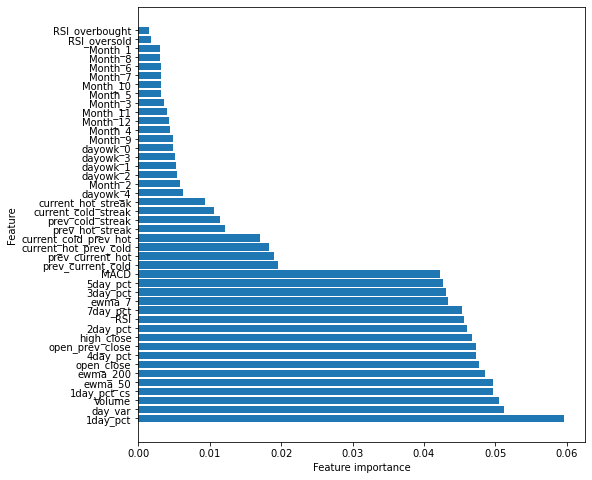

In [28]:
forest = RandomForestClassifier(n_estimators=3000, max_depth= 10)
forest.fit(X_train, y_train)
print(forest.score(X_test, y_test))

plot_feature_importances(forest,n_features=50)